# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
import constants
importlib.reload(constants)
from constants import *

import functions_analysis
import functions_job_creation
import functions_filtering
import functions_plotting
import functions_download
import functions_pdb2net
import functions_cif

# Reload the module
importlib.reload(functions_analysis)
importlib.reload(functions_job_creation)
importlib.reload(functions_filtering)
importlib.reload(functions_download)
importlib.reload(functions_plotting)
importlib.reload(functions_pdb2net)
importlib.reload(functions_cif)


from functions_analysis import *
from functions_job_creation import *
from functions_download import *
from functions_filtering import *
from functions_plotting import *
from functions_pdb2net import *
from functions_cif import *

# 2. Filter

In [2]:
rep = pd.read_csv('/home/markus/MPI_local/data/PDB_reports/4/combined_pdb_reports_processed.csv', low_memory=False)

In [3]:
# remove rows with NaN in sequence field (ligands etc.)
print(f"Before removing NaN sequences: {len(rep)}")
rep = rep.dropna(subset=['Sequence'])
print(f"After removing NaN sequences: {len(rep)}")

Before removing NaN sequences: 65803
After removing NaN sequences: 39450


In [4]:
# length filter
MIN_LENGTH = 20

print(f"Before length filter: {len(rep)}")
rep['Sequence length'] = rep['Sequence'].fillna('').str.len()
rep = rep[rep['Sequence length'] >= MIN_LENGTH]
print(f"After length filter: {len(rep)}")

Before length filter: 39450
After length filter: 32971


In [5]:
rep = add_iupred3(rep, 'long', 'no', IUPRED_CACHE_DIR, IUPRED3_THRESHOLD, MIN_LENGTH_DISORDERED_REGION, IUPRED3_PATH, debug=False)

In [6]:
# filter out all PDBs that don't have at least 1 disordered chain
print(len(rep))
keep_pdbs = set()
for _, row in rep.iterrows():
    if row['num_disordered_regions'] > 0:
        keep_pdbs.add(row['Entry ID'])
        
rep = rep[rep['Entry ID'].isin(keep_pdbs)]

print(len(rep))

32971
9836


In [7]:
# filter out all PDBs that don't have at least 1 ordered chain
print(len(rep))
keep_pdbs = set()
for _, row in rep.iterrows():
    if row['num_disordered_regions'] == 0:
        keep_pdbs.add(row['Entry ID'])
        
rep = rep[rep['Entry ID'].isin(keep_pdbs)]

print(len(rep))

9836
8767


In [8]:
# write into directory for PDB2Net processing
PDB2NET_PREFIX = '/home/markus/PDB2Net/in/'
path_prefix = PDB2NET_PREFIX + 'pipeline2/'
rep['model_path'] = rep['Entry ID'].apply(lambda id: path_prefix + id.lower() + '.cif')

rep.drop_duplicates(subset=['model_path'], inplace=False)['model_path'].to_csv(PDB2NET_PREFIX + 'pipeline2.csv', index=False)

# download pdb structures for pdb2net
download_pdb_structures(set(rep['Entry ID'].tolist()), path_prefix, 'cif', '/home/markus/MPI_local/data/PDB', debug=False)

In [9]:
# annotate interface
# define interface as having at least INTERFACE_MIN_ATOMS atoms within INTERFACE_MAX_DISTANCE A of each other
INTERFACE_MIN_ATOMS = 10
INTERFACE_MAX_DISTANCE = 5 # higher not possible => change PDB2Net data
PATH = '/home/markus/MPI_local/data/PDB2Net/pipeline2/2025-08-28_19-38-42'
interfaces_df = get_interfaces_pdb2net(PATH, INTERFACE_MIN_ATOMS, INTERFACE_MAX_DISTANCE, rep)

Processing: 0/8129
Processing: 812/8129
Processing: 1624/8129
Processing: 2436/8129
Processing: 3248/8129
Processing: 4060/8129
Processing: 4872/8129
Processing: 5684/8129
Processing: 6496/8129
Processing: 7308/8129
Processing: 8120/8129
No model found for: []


In [10]:
# Deduplicate interfaces based on UniProt IDs
print(f"Before deduplication: {len(interfaces_df)} interfaces")

interfaces_df['normalized_uniprot'] = interfaces_df['Uniprot IDs'].apply(normalize_uniprot_pair)
interfaces_df = interfaces_df.drop_duplicates(subset=['normalized_uniprot'])
interfaces_df = interfaces_df.drop('normalized_uniprot', axis=1)

print(f"After deduplication: {len(interfaces_df)} interfaces")

Before deduplication: 22415 interfaces
After deduplication: 3852 interfaces


In [11]:
# use only interactions between ordered-disordered chain
rep_reindex = rep.copy()

rep_reindex.set_index(['Entry ID', 'Asym ID'], inplace=True)

import json
print(len(interfaces_df))

for ind,row in interfaces_df.iterrows():
    interface_id = json.loads(row['Interface ID'].replace('\'', '"'))
    chainID_1 = interface_id[0]
    chainID_2 = interface_id[1]
    try:
        disorder_chain1 = int(rep_reindex.loc[(row['Entry ID'], chainID_1), 'num_disordered_regions'])
        disorder_chain2 = int(rep_reindex.loc[(row['Entry ID'], chainID_2), 'num_disordered_regions'])
    except KeyError as e:
        # Skip this interface if entry/chain not found
        print(f"Entry not found: {e}")
        interfaces_df.drop(ind, inplace=True)
        continue
    
    if not ((disorder_chain1 == 0 and disorder_chain2 >= 1) or (disorder_chain2 == 0 and disorder_chain1 >= 1)):
        interfaces_df.drop(ind, inplace=True)
        
print(len(interfaces_df))

3852
Entry not found: ('1D8D', 'P')
Entry not found: ('1D8D', 'P')
Entry not found: ('1DEE', 'A')
Entry not found: ('1DEE', 'D')
Entry not found: ('1DEE', 'H')
Entry not found: ('1DU3', 'E')
Entry not found: ('1FM6', 'A')
Entry not found: ('1FM6', 'A')
Entry not found: ('1FM6', 'A')
Entry not found: ('1FM6', 'D')
Entry not found: ('1FS1', 'A')
Entry not found: ('1FS1', 'D')
Entry not found: ('1FS2', 'A')
Entry not found: ('1G3J', 'C')
Entry not found: ('1G4U', 'S')
Entry not found: ('1GNG', 'B')
Entry not found: ('1GNG', 'X')
Entry not found: ('1GO4', 'A')
Entry not found: ('1GO4', 'A')
Entry not found: ('1GO4', 'F')
Entry not found: ('1H2K', 'S')
Entry not found: ('1HEZ', 'C')
Entry not found: ('1HH4', 'D')
Entry not found: ('1I2M', 'D')
Entry not found: ('1IM9', 'E')
Entry not found: ('1J1D', 'F')
Entry not found: ('1K2D', 'P')
Entry not found: ('1K2D', 'P')
Entry not found: ('1K5D', 'F')
Entry not found: ('1K7L', 'A')
Entry not found: ('1K7L', 'A')
Entry not found: ('1K90', 'D')
Ent

In [12]:
# annotate interfaces with data
interfaces_df['Release Date'] = interfaces_df['Entry ID'].map(rep.groupby('Entry ID')['Release Date'].first())

In [13]:
interfaces_df['in_training_set'] = interfaces_df['Release Date'] <= AF_TRAINING_CUTOFF

In [14]:
up_ids_structure_ds = interfaces_df['Uniprot IDs'].tolist()
%store up_ids_structure_ds

Stored 'up_ids_structure_ds' (list)


# 3. Job Creation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions_filtering import *

import importlib
import constants
importlib.reload(constants)
from constants import *

import functions_analysis
import functions_job_creation
import functions_filtering
import functions_plotting
import functions_download
import functions_pdb2net

# Reload the module
importlib.reload(functions_analysis)
importlib.reload(functions_job_creation)
importlib.reload(functions_filtering)
importlib.reload(functions_download)
importlib.reload(functions_plotting)
importlib.reload(functions_pdb2net)

from functions_analysis import *
from functions_job_creation import *
from functions_download import *
from functions_filtering import *
from functions_plotting import *
from functions_pdb2net import *

In [16]:
BATCH_DIRS = []
BATCH_DIRS.extend([os.path.join('../../production1/PDB_modelling/', d) for d in os.listdir('../../production1/PDB_modelling') if os.path.isdir(os.path.join('../../production1/PDB_modelling', d)) and 'batch' in d])

interfaces_df.rename(columns={'Interface ID': 'Chains'}, inplace=True)
new_af_jobs, reference_jobs = create_job_batch_from_PDB_chains(interfaces_df, BATCH_DIRS, 5120)
write_af_jobs_to_individual_files(new_af_jobs, '../../production1/PDB_modelling/batch_12')
write_af_jobs_to_individual_files(reference_jobs, '../../production1/PDB_modelling/reference', 'alphafold3', True)
interfaces_df.rename(columns={'Chains': 'Interface ID'}, inplace=True)

All job IDs already have existing directories in target location: ['1c5w', '1c5w_a_b']
All job IDs already have existing directories in target location: ['1doa', '1doa_a_b']
Error while processing sequences for 1dzi: sequence contains non-standard amino acids or nucleotides: GPPGPPGFPGERGPPGPPGPPX, ID: 1dzi
Empty sequence list: 1DZI
All job IDs already have existing directories in target location: ['1jdh', '1jdh', '1jdh_a_b']
All job IDs already have existing directories in target location: ['1jeq', '1jeq_a_b']
All job IDs already have existing directories in target location: ['1mk2', '1mk2_a_b']
All job IDs already have existing directories in target location: ['8suy', '1n52_a_b']
All job IDs already have existing directories in target location: ['1nfu', '1nfu_a_b']
All job IDs already have existing directories in target location: ['1nw9', '1nw9_a_b']
All job IDs already have existing directories in target location: ['1oe9', '1oe9_a_b']
All job IDs already have existing directories in

# 4. Analysis

In [17]:
results_df = interfaces_df.copy()
results_df.rename(columns={'Chains': 'Interface ID'}, inplace=True)
results_df.rename(columns={'pdb_id': 'Entry ID'}, inplace=True)

In [18]:
NATIVE_PATH_PREFIX = "/home/markus/MPI_local/data/PDB/"
HPC_FULL_RESULTS_DIR = "/home/markus/MPI_local/HPC_results_full"
PDB_CACHE = '../../production1/pdb_cache'
DOCKQ_CACHE = '../../production1/dockq_cache_p2'
JOB_DIR = '/home/markus/MPI_local/production1/PDB_modelling'
# rename columns for compatibility with annotate_dockq()
results_df['job_name'] = results_df.apply(lambda row: row['Entry ID'] + "_" + "_".join(eval(row['Interface ID'])), axis=1)
results_df.rename(columns={'Entry ID': 'pdb_id'}, inplace=True)
results_df, no_model = append_dockq_two_chainIDs(results_df, NATIVE_PATH_PREFIX, HPC_FULL_RESULTS_DIR, JOB_DIR, PDB_CACHE, DOCKQ_CACHE)
results_df.rename(columns={'pdb_id': 'Entry ID'}, inplace=True)

1C5W_A_B
Processed 0 of 1194 rows.
1c5w_a_b
used cached entry for: 1C5W_A_B
1D8D_A_B
1d8d_a_b
1DEV_A_B
1dev_a_b
1DOA_A_B
1doa_a_b
used cached entry for: 1DOA_A_B
1DU3_A_D
1du3_a_d
1DZI_A_B
1dzi_a_b
1EF1_A_B
1ef1_a_b
Exception for 1EF1: KeyError('B').
1G3J_A_B
1g3j_a_b
1HEZ_A_B
1hez_a_b
1I2M_A_B
1i2m_a_b
1I3O_A_B
Processed 10 of 1194 rows.
1i3o_a_b
1I3O_A_E
1i3o_a_e
1IM9_A_D
1im9_a_d
1J1D_A_C
1j1d_a_c
1J1D_B_C
1j1d_b_c
1JDH_A_B
1jdh_a_b
used cached entry for: 1JDH_A_B
1JEQ_A_B
1jeq_a_b
used cached entry for: 1JEQ_A_B
1K5D_A_B
1k5d_a_b
1K5D_A_C
1k5d_a_c
1K90_A_B
1k90_a_b
Exception for 1K90: KeyError('B').
1KIL_A_C
Processed 20 of 1194 rows.
1kil_a_c
1KIL_A_E
1kil_a_e
1KIL_B_C
1kil_b_c
1KIL_B_E
1kil_b_e
1LB1_A_B
1lb1_a_b
1LJ2_A_C
1lj2_a_c
1MI5_A_D
1mi5_a_d
1MK2_A_B
1mk2_a_b
used cached entry for: 1MK2_A_B
1MUJ_A_C
1muj_a_c
1MUJ_B_C
1muj_b_c
1N4P_A_B
Processed 30 of 1194 rows.
1n4p_a_b
1N52_A_B
1n52_a_b
used cached entry for: 1N52_A_B
1NFU_A_B
1nfu_a_b
used cached entry for: 1NFU_A_B
1NIW_

In [19]:
print(no_model)
find_job_files(no_model, '/home/markus/MPI_local/production1')

['1DZI_A_B', '3D24_A_B', '3D2E_A_B', '3D85_A_C', '3D85_B_C', '3D85_C_D', '3DAC_A_B', '3DXC_A_B', '3E4Z_A_C', '3EAB_A_G', '3EYF_A_B', '3EZQ_A_B', '3F12_A_B', '3F7P_A_C', '3F8U_A_B', '3FEY_A_C', '3GJ7_A_B', '3GJO_A_E', '3GJX_B_A', '3GJX_C_A', '3GP2_A_B', '3H0T_B_C', '3H3B_A_C', '3H6S_A_E', '3HVE_A_B', '3HVQ_A_C', '3ICI_A_C', '3IEC_A_E', '3IFQ_A_C', '3IHP_A_C', '3IT8_A_D', '3KYS_A_B', '3LGE_A_E', '3LW8_A_E', '3MI9_A_C', '3MI9_B_C', '3MTU_A_E', '3NMX_A_D', '3NVQ_A_B', '3O6F_A_B', '3O6F_A_C', '3O6F_B_D', '3O6F_C_D', '3OF6_A_D', '3OFI_A_C', '3OVU_B_C', '3P6Z_B_C', '3P8C_A_B', '3P8M_A_C', '3PK1_A_B', '3PNW_B_C', '3Q2S_A_C', '3QB4_A_B', '3QDM_A_E', '3QDM_D_E', '3QEQ_A_E', '3QEQ_D_E', '3QFA_A_C', '3QHE_A_B', '3QO0_A_C', '3QO0_B_C', '3R45_A_C', '3R66_A_C', '3R9A_A_B', '3RK2_A_C', '3RWJ_A_B', '3TJ3_A_B', '3TQ7_A_B', '3U5N_A_B', '3U7X_A_C', '3UIN_A_B', '3UIN_B_C', '3UIN_B_D', '3UM1_A_B', '3UVJ_A_B', '3V4Y_A_B', '3VE1_A_B', '3VHX_A_B', '3W8J_A_C', '3WA0_A_G', '3WGX_A_C', '3ZKJ_A_C', '3ZRZ_A_C', '4A

(['/home/markus/MPI_local/production1/PDB_modelling/batch_11/3D24_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3D2E_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3D85_A_C.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3D85_B_C.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3D85_C_D.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3DAC_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3DXC_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3E4Z_A_C.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3EAB_A_G.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3EZQ_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3F12_A_B.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3F7P_A_C.json',
  '/home/markus/MPI_local/production1/PDB_modelling/batch_11/3F8U_A_B.json',

In [20]:
results_df = annotate_AF_metrics(results_df, '/home/markus/MPI_local/HPC_results_full')

Duplicate jobs: 692
Initial dataset size: 1175 rows
After filtering ranking_score [-100,1.5]: 1175 rows (0 removed)
After filtering iptm [0,1]: 1150 rows (25 removed)
After filtering ptm [0,1]: 1150 rows (0 removed)
Total rows removed: 25 (2.13%)


In [21]:
results_df = results_df.dropna(subset=['dockq_score'])

# 5. Plotting

In [104]:
def spd(df: pd.DataFrame, x_metric: str, y_metric: str,
                        title: str = '', cmap: str = 'viridis', alpha: float = 0.9, size: int = 50, ax=None, corr=False, legend_position='left') -> None:


    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        show_plot = True
    else:
        show_plot = False
    
    # Create scatter plot with color mapping for boolean values
    # Map boolean values to colors manually to ensure consistency
    colors = df['in_training_set'].map({False: "#DD8452", True: "#4C72B0"})  # Orange for False, Blue for True
    
    scatter = ax.scatter(
        x=df[x_metric], 
        y=df[y_metric], 
        c=colors,
        alpha=alpha,
        s=size,
        edgecolors='w'
    )

    # Add labels and title
    ax.set_xlabel(x_metric, fontsize=12)
    ax.set_ylabel('DockQ score', fontsize=12)
    ax.set_title(title, fontsize=12)

    # Add a grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Create custom legend for boolean values with matching colors
    import matplotlib.patches as mpatches
    false_patch = mpatches.Patch(color='#DD8452', label='Not in Training Set')
    true_patch = mpatches.Patch(color='#4C72B0', label='In Training Set')
    
    # Set legend position based on parameter
    if legend_position == 'right':
        legend_loc = 'upper right'
    else:
        legend_loc = 'upper left'
    
    ax.legend(loc=legend_loc, handles=[false_patch, true_patch])

    # Add number of datapoints as a text box
    num_points = len(df)
    in_training_count = df['in_training_set'].sum()
    not_in_training_count = num_points - in_training_count
    in_training_pct = (in_training_count / num_points * 100) if num_points > 0 else 0
    not_in_training_pct = (not_in_training_count / num_points * 100) if num_points > 0 else 0
    
    annotation_text = f'Datapoints: {num_points}\nIn training: {in_training_count} ({in_training_pct:.1f}%)\nNot in training: {not_in_training_count} ({not_in_training_pct:.1f}%)'
    
    # Calculate and add correlation coefficient if requested
    if corr:
        # Filter out rows with missing values for correlation calculation
        valid_corr_data = df[[x_metric, y_metric]].dropna()
        if len(valid_corr_data) > 1:  # Need at least 2 points for correlation
            correlation = valid_corr_data[x_metric].corr(valid_corr_data[y_metric])
            annotation_text += f'\nPearson r: {correlation:.3f}'
        else:
            annotation_text += f'\nPearson r: N/A (insufficient data)'
    
    # Set annotation position based on parameter
    if legend_position == 'right':
        xy_pos = (0.975, 0.72)
        ha_align = 'right'
    else:
        xy_pos = (0.025, 0.72)
        ha_align = 'left'
    
    ax.annotate(annotation_text, xy=xy_pos, xycoords='axes fraction', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                ha=ha_align)

    # Show plot only if not using subplots
    if show_plot:
        plt.tight_layout()
        plt.show()

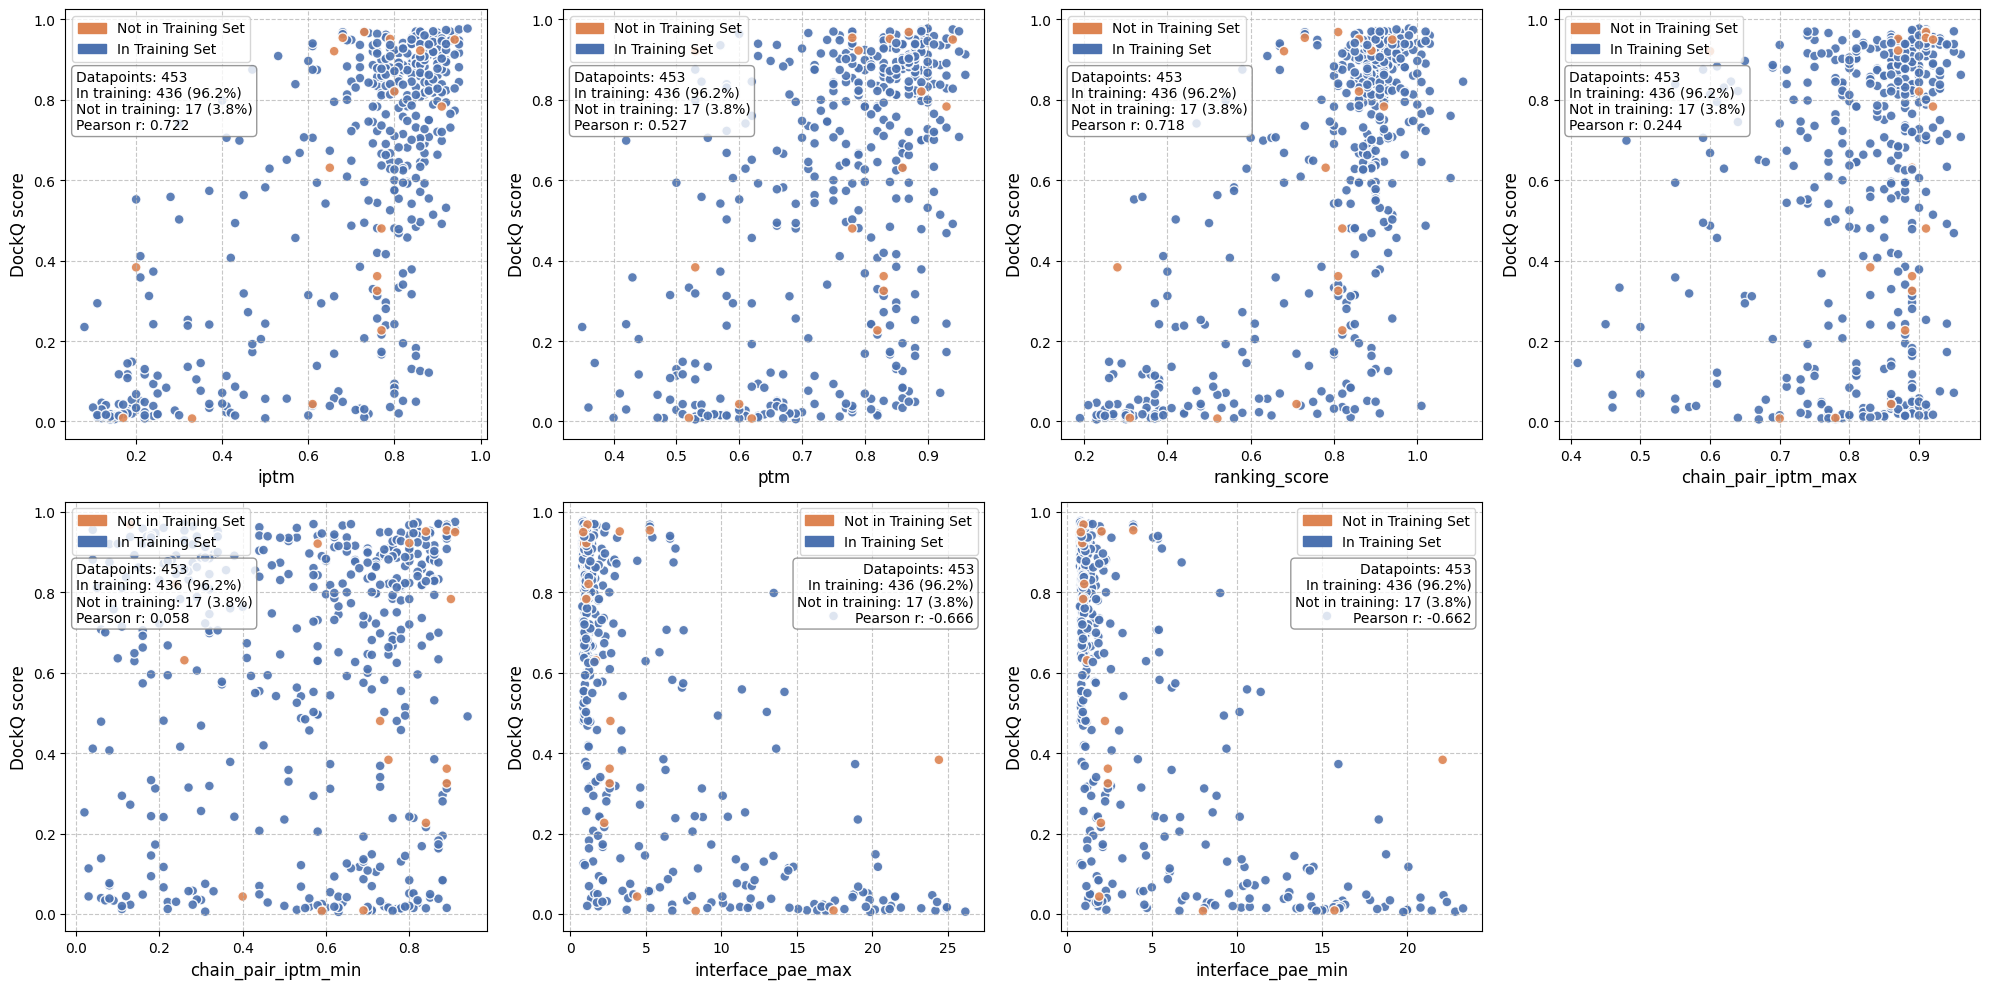

In [105]:
# Create a 2-row subplot grid with 4 plots in first row and 3 plots in second row
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# First row: 4 plots
spd(results_df, 'iptm', 'dockq_score', ax=axes[0, 0], corr=True)
spd(results_df, 'ptm', 'dockq_score', ax=axes[0, 1], corr=True)
spd(results_df, 'ranking_score', 'dockq_score', ax=axes[0, 2], corr=True)
spd(results_df, 'chain_pair_iptm_max', 'dockq_score', ax=axes[0, 3], corr=True)

# Second row: 3 plots (hide the 4th subplot)
spd(results_df, 'chain_pair_iptm_min', 'dockq_score', ax=axes[1, 0], corr=True)
spd(results_df, 'interface_pae_max', 'dockq_score', ax=axes[1, 1], corr=True, legend_position='right')
spd(results_df, 'interface_pae_min', 'dockq_score', ax=axes[1, 2], corr=True, legend_position='right')
axes[1, 3].set_visible(False)  # Hide the 4th subplot in second row

plt.tight_layout()
plt.savefig('/home/markus/Desktop/Thesis/structure_scatter.png', dpi=300)
plt.show()

/tmp/ipykernel_32598/1516118129.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


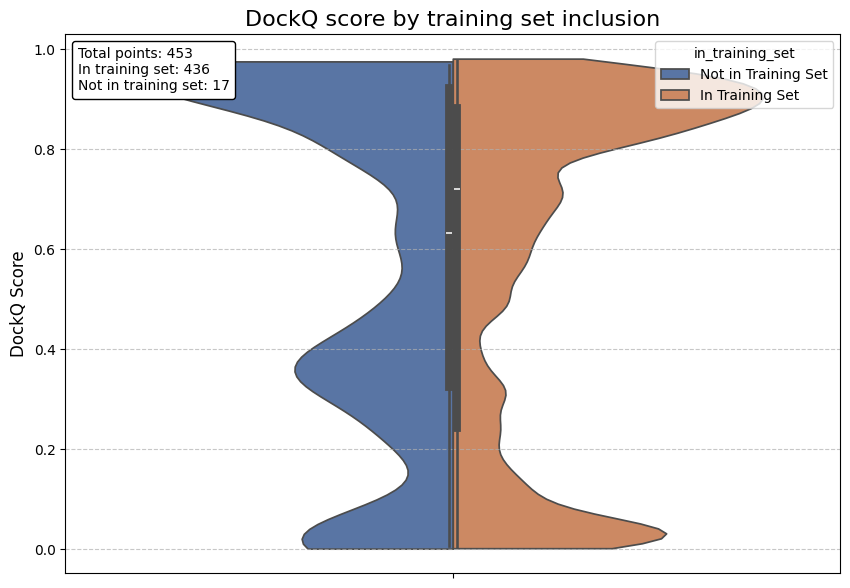

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Create the violin plot
plt.figure(figsize=(10, 7))

# Add a constant column to use for the x-axis to create a single split violin
results_df['status'] = 'DockQ'

# Use a split violin plot with bounded KDE using seaborn's default 'deep' palette
ax = sns.violinplot (data=results_df, x='status', y='dockq_score', hue='in_training_set', 
                   split=True, palette='deep', inner='box', bw_adjust=0.3, cut=0.1)


# Manually add legend for hue
handles, labels = ax.get_legend_handles_labels()
labels = ['Not in Training Set', 'In Training Set']
ax.legend(handles, labels, title='in_training_set', loc='upper right')


# Calculate counts for the legend
total_points = len(results_df)
in_training_count = results_df['in_training_set'].sum()
not_in_training_count = total_points - in_training_count

# Create legend text
legend_text = (
    f'Total points: {total_points}\n'
    f'In training set: {in_training_count}\n'
    f'Not in training set: {not_in_training_count}'
)

# Add legend to the plot using a text box
at = AnchoredText(legend_text, prop=dict(size=10), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)


# Set plot title and labels
ax.set_title('DockQ score by training set inclusion', fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels([''])
ax.set_ylabel('DockQ Score', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Clean up the temporary column
results_df.drop(columns=['status'], inplace=True)

plt.savefig('/home/markus/Desktop/Thesis/structure_violin.png', dpi=300)
plt.show()

## AUR / PR curve

Dataset Class Distribution:
Total samples: 453
Positive samples (dockQ >= 0.23): 344 (0.759)
Negative samples (dockQ < 0.23): 109 (0.241)

AUC Results and Optimal Cutoffs:
iptm:
  PR-AUC: 0.9551
  ROC-AUC: 0.8824
  Optimal F1 cutoff: 0.4400 (F1 = 0.9153)
  Optimal Youden cutoff: 0.6900 (J = 0.6287)

ranking_score:
  PR-AUC: 0.9558
  ROC-AUC: 0.8948
  Optimal F1 cutoff: 0.5500 (F1 = 0.9160)
  Optimal Youden cutoff: 0.8100 (J = 0.6358)

ptm:
  PR-AUC: 0.9062
  ROC-AUC: 0.7801
  Optimal F1 cutoff: 0.5700 (F1 = 0.8809)
  Optimal Youden cutoff: 0.7200 (J = 0.4682)

chain_pair_iptm_max:
  PR-AUC: 0.8281
  ROC-AUC: 0.6141
  Optimal F1 cutoff: 0.4700 (F1 = 0.8651)
  Optimal Youden cutoff: 0.8300 (J = 0.1877)

chain_pair_iptm_min:
  PR-AUC: 0.7782
  ROC-AUC: 0.5154
  Optimal F1 cutoff: 0.0400 (F1 = 0.8640)
  Optimal Youden cutoff: 0.7200 (J = 0.0772)

interface_pae_max:
  PR-AUC: 0.9634
  ROC-AUC: 0.9053
  Optimal F1 cutoff: 7.5000 (F1 = 0.9188)
  Optimal Youden cutoff: 3.2700 (J = 0.6606)

int

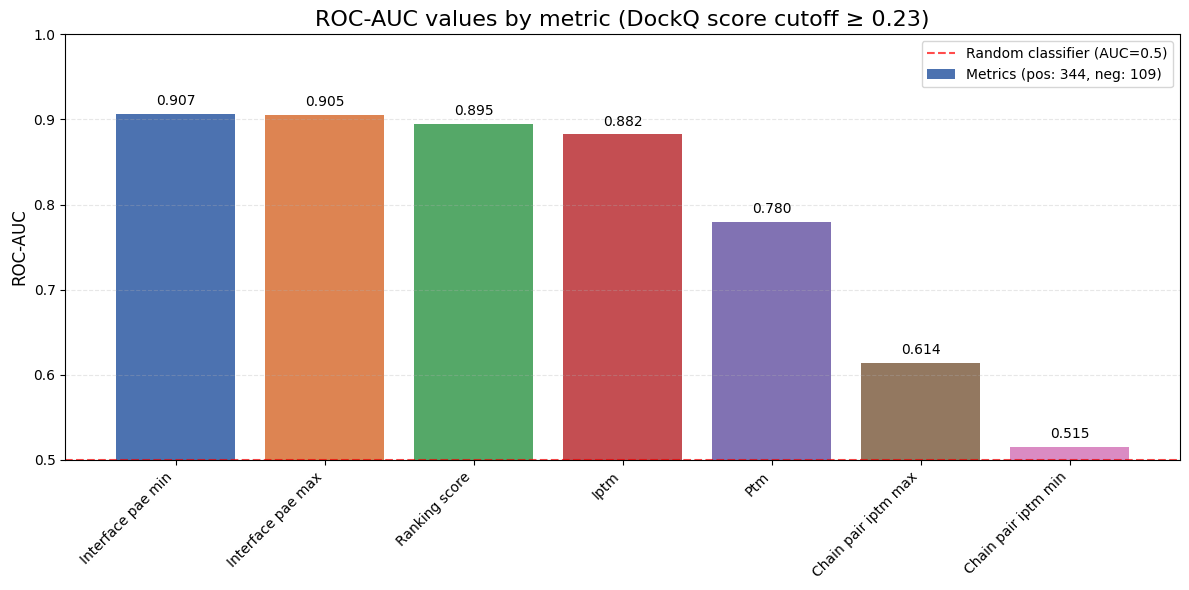

In [107]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Define DockQ cutoff threshold
DOCKQ_CUTOFF = 0.23

# Define the metrics to evaluate
metrics = ['iptm', 'ranking_score', 'ptm', 'chain_pair_iptm_max', 'chain_pair_iptm_min', 
           'interface_pae_max', 'interface_pae_min']

# Create binary labels based on dockQ
y_true = (results_df['dockq_score'] >= DOCKQ_CUTOFF).astype(int)

# Report number of 1s and 0s in y_true
print("Dataset Class Distribution:")
print(f"Total samples: {len(y_true)}")
print(f"Positive samples (dockQ >= {DOCKQ_CUTOFF}): {y_true.sum()} ({y_true.mean():.3f})")
print(f"Negative samples (dockQ < {DOCKQ_CUTOFF}): {len(y_true) - y_true.sum()} ({1 - y_true.mean():.3f})")
print()

print("AUC Results and Optimal Cutoffs:")
print("=" * 60)

auc_results = {}

for metric in metrics:
    # Get predictions (higher values should indicate better models for most metrics)
    # For PAE metrics, we need to invert since lower PAE is better
    if 'pae' in metric:
        y_scores = -results_df[metric]  # Invert PAE scores
        original_scores = results_df[metric]  # Keep original for cutoff reporting
    else:
        y_scores = results_df[metric]
        original_scores = results_df[metric]
    
    # Remove NaN values
    mask = ~(y_scores.isna() | y_true.isna())
    y_scores_clean = y_scores[mask]
    y_true_clean = y_true[mask]
    original_scores_clean = original_scores[mask]
    
    if len(y_scores_clean) == 0:
        print(f"{metric}: No valid data")
        continue
    
    # Calculate PR curve and AUC
    precision, recall, pr_thresholds = precision_recall_curve(y_true_clean, y_scores_clean)
    pr_auc = auc(recall, precision)
    
    # Calculate ROC curve and AUC
    fpr, tpr, roc_thresholds = roc_curve(y_true_clean, y_scores_clean)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal cutoffs
    # 1. F1-score optimal cutoff (from PR curve)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero
    optimal_f1_idx = np.argmax(f1_scores)
    optimal_f1_threshold = pr_thresholds[optimal_f1_idx]
    optimal_f1_score = f1_scores[optimal_f1_idx]
    
    # 2. Youden's J statistic optimal cutoff (from ROC curve)
    # J = sensitivity + specificity - 1 = tpr - fpr
    youden_j = tpr - fpr
    optimal_youden_idx = np.argmax(youden_j)
    optimal_youden_threshold = roc_thresholds[optimal_youden_idx]
    optimal_youden_j = youden_j[optimal_youden_idx]
    
    # Convert back to original scale for PAE metrics
    if 'pae' in metric:
        optimal_f1_threshold_original = -optimal_f1_threshold
        optimal_youden_threshold_original = -optimal_youden_threshold
    else:
        optimal_f1_threshold_original = optimal_f1_threshold
        optimal_youden_threshold_original = optimal_youden_threshold
    
    auc_results[metric] = {
        'PR_AUC': pr_auc, 
        'ROC_AUC': roc_auc,
        'optimal_f1_threshold': optimal_f1_threshold_original,
        'optimal_f1_score': optimal_f1_score,
        'optimal_youden_threshold': optimal_youden_threshold_original,
        'optimal_youden_j': optimal_youden_j
    }
    
    print(f"{metric}:")
    print(f"  PR-AUC: {pr_auc:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  Optimal F1 cutoff: {optimal_f1_threshold_original:.4f} (F1 = {optimal_f1_score:.4f})")
    print(f"  Optimal Youden cutoff: {optimal_youden_threshold_original:.4f} (J = {optimal_youden_j:.4f})")
    print()

# Create a histogram of ROC-AUC values for all metrics
plt.figure(figsize=(12, 6))

# Extract ROC-AUC values and sort them in descending order
roc_auc_values = {m: auc_results[m]['ROC_AUC'] for m in metrics if m in auc_results}
sorted_metrics = sorted(roc_auc_values.keys(), key=lambda x: roc_auc_values[x], reverse=True)
sorted_values = [roc_auc_values[m] for m in sorted_metrics]

# Create more readable labels by replacing underscores with spaces and capitalizing
readable_labels = [m.replace('_', ' ').capitalize() for m in sorted_metrics]

# Use seaborn deep color palette for the bars
import seaborn as sns
colors = sns.color_palette("deep", len(sorted_metrics))

# Create the bar chart with different colors for each bar
bars = plt.bar(range(len(sorted_metrics)), sorted_values, color=colors, edgecolor='none')

# Add value labels on top of each bar
for i, v in enumerate(sorted_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# Get class distribution for legend
pos_samples = y_true.sum()
neg_samples = len(y_true) - pos_samples

# Customize the plot
plt.xticks(range(len(sorted_metrics)), readable_labels, rotation=45, ha='right')
plt.ylim(0.5, 1.0)  # Start y-axis from 0.5 to better show differences
plt.title(f'ROC-AUC values by metric (DockQ score cutoff ≥ {DOCKQ_CUTOFF})', fontsize=16)
plt.ylabel('ROC-AUC', fontsize=12)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random classifier (AUC=0.5)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(['Random classifier (AUC=0.5)', f'Metrics (pos: {pos_samples}, neg: {neg_samples})'])
plt.tight_layout()

plt.savefig('/home/markus/Desktop/Thesis/structure_bar.png', dpi=300)
plt.show()

Class Distribution for DockQ cutoff ≥ 0.23:
Positive samples: 344 (0.759)
Negative samples: 109 (0.241)

Class Distribution for DockQ cutoff ≥ 0.8:
Positive samples: 193 (0.426)
Negative samples: 260 (0.574)



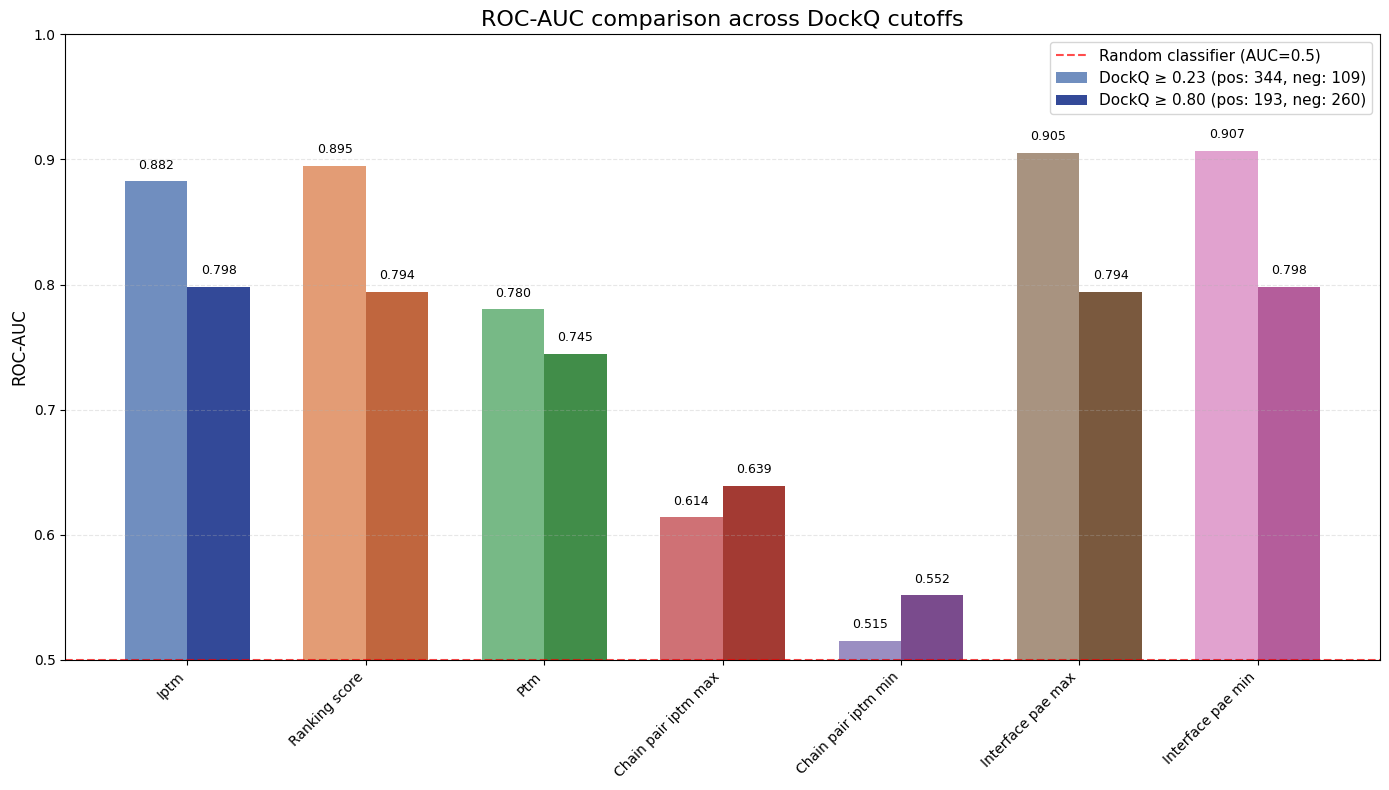


ROC-AUC Comparison Table:
Metric                    DockQ ≥ 0.23    DockQ ≥ 0.80    Difference
----------------------------------------------------------------------
iptm                      0.8824          0.7983          +0.0841   
ranking_score             0.8948          0.7944          +0.1004   
ptm                       0.7801          0.7449          +0.0352   
chain_pair_iptm_max       0.6141          0.6393          -0.0252   
chain_pair_iptm_min       0.5154          0.5517          -0.0363   
interface_pae_max         0.9053          0.7944          +0.1109   
interface_pae_min         0.9069          0.7982          +0.1086   


In [108]:
# Create comparison plot for ROC-AUC values at different DockQ cutoffs
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define DockQ cutoff thresholds
DOCKQ_CUTOFFS = [0.23, 0.80]

# Define the metrics to evaluate
metrics = ['iptm', 'ranking_score', 'ptm', 'chain_pair_iptm_max', 'chain_pair_iptm_min',
           'interface_pae_max', 'interface_pae_min']

# Store results for both cutoffs
comparison_results = {}

for cutoff in DOCKQ_CUTOFFS:
    # Create binary labels based on dockQ cutoff
    y_true = (results_df['dockq_score'] >= cutoff).astype(int)

    # Report class distribution
    print(f"Class Distribution for DockQ cutoff ≥ {cutoff}:")
    print(f"Positive samples: {y_true.sum()} ({y_true.mean():.3f})")
    print(f"Negative samples: {len(y_true) - y_true.sum()} ({1 - y_true.mean():.3f})")
    print()
    
    cutoff_results = {}
    
    for metric in metrics:
        # Get predictions (higher values should indicate better models for most metrics)
        # For PAE metrics, we need to invert since lower PAE is better
        if 'pae' in metric:
            y_scores = -results_df[metric]  # Invert PAE scores
        else:
            y_scores = results_df[metric]
        
        # Remove NaN values
        mask = ~(y_scores.isna() | y_true.isna())
        y_scores_clean = y_scores[mask]
        y_true_clean = y_true[mask]
        
        if len(y_scores_clean) == 0:
            continue
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_clean, y_scores_clean)
        roc_auc = auc(fpr, tpr)
        
        cutoff_results[metric] = roc_auc
    
    comparison_results[cutoff] = cutoff_results

# Create the comparison bar plot
plt.figure(figsize=(14, 8))

# Prepare data for plotting
x_pos = np.arange(len(metrics))
width = 0.35  # Width of bars

# Get ROC-AUC values for both cutoffs
roc_auc_023 = [comparison_results[0.23].get(m, np.nan) for m in metrics]
roc_auc_080 = [comparison_results[0.80].get(m, np.nan) for m in metrics]

# Create more readable labels
readable_labels = [m.replace('_', ' ').capitalize() for m in metrics]

# Use different color palettes for each cutoff
colors_deep = sns.color_palette("deep", len(metrics))
colors_bright = sns.color_palette("dark", len(metrics))

# Create grouped bar chart with different colors for each metric
bars1 = plt.bar(x_pos - width/2, roc_auc_023, width, label='DockQ ≥ 0.23', 
                color=colors_deep, alpha=0.8, edgecolor='none')
bars2 = plt.bar(x_pos + width/2, roc_auc_080, width, label='DockQ ≥ 0.80', 
                color=colors_bright, alpha=0.8, edgecolor='none')

# Add value labels on top of each bar
for i, (v1, v2) in enumerate(zip(roc_auc_023, roc_auc_080)):
    if not np.isnan(v1):
        plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center', fontsize=9)
    if not np.isnan(v2):
        plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center', fontsize=9)

# Get sample counts for legend
y_true_023 = (results_df['dockq_score'] >= 0.23).astype(int)
y_true_080 = (results_df['dockq_score'] >= 0.80).astype(int)
pos_023 = y_true_023.sum()
neg_023 = len(y_true_023) - pos_023
pos_080 = y_true_080.sum()
neg_080 = len(y_true_080) - pos_080

# Customize the plot
plt.xticks(x_pos, readable_labels, rotation=45, ha='right')
plt.ylim(0.5, 1.0)  # Start y-axis from 0.5 to better show differences
plt.title('ROC-AUC comparison across DockQ cutoffs', fontsize=16)
plt.ylabel('ROC-AUC', fontsize=12)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random classifier (AUC=0.5)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Create custom legend with sample counts
legend_labels = [
    'Random classifier (AUC=0.5)',
    f'DockQ ≥ 0.23 (pos: {pos_023}, neg: {neg_023})',
    f'DockQ ≥ 0.80 (pos: {pos_080}, neg: {neg_080})',
]
plt.legend(legend_labels, fontsize=11)
plt.tight_layout()

plt.savefig('/home/markus/Desktop/Thesis/structure_bar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary table
print("\nROC-AUC Comparison Table:")
print("=" * 70)
print(f"{'Metric':<25} {'DockQ ≥ 0.23':<15} {'DockQ ≥ 0.80':<15} {'Difference':<10}")
print("-" * 70)

for metric in metrics:
    auc_023 = comparison_results[0.23].get(metric, np.nan)
    auc_080 = comparison_results[0.80].get(metric, np.nan)
    diff = auc_023 - auc_080 if not (np.isnan(auc_023) or np.isnan(auc_080)) else np.nan
    
    auc_023_str = f"{auc_023:.4f}" if not np.isnan(auc_023) else "N/A"
    auc_080_str = f"{auc_080:.4f}" if not np.isnan(auc_080) else "N/A"
    diff_str = f"{diff:+.4f}" if not np.isnan(diff) else "N/A"
    
    print(f"{metric:<25} {auc_023_str:<15} {auc_080_str:<15} {diff_str:<10}")

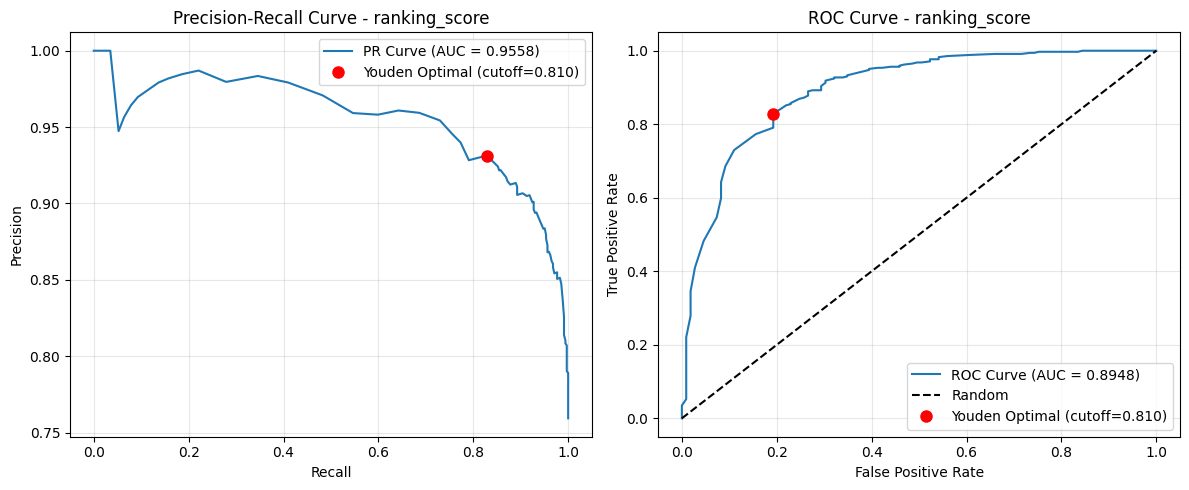

In [109]:
# Plot Precision-Recall and ROC curves for ranking_score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get ranking_score data
metric = 'ranking_score'
y_scores = results_df[metric]
y_true = (results_df['dockq_score'] >= 0.23).astype(int)

# Remove NaN values
mask = ~(y_scores.isna() | y_true.isna())
y_scores_clean = y_scores[mask]
y_true_clean = y_true[mask]

# Calculate and plot PR curve
precision, recall, pr_thresholds = precision_recall_curve(y_true_clean, y_scores_clean)
pr_auc = auc(recall, precision)
ax1.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')

# Calculate and plot ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_true_clean, y_scores_clean)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random')

# Find optimal cutoff using Youden's J statistic
youden_j = tpr - fpr
optimal_youden_idx = np.argmax(youden_j)
optimal_youden_threshold = roc_thresholds[optimal_youden_idx]
optimal_youden_tpr = tpr[optimal_youden_idx]
optimal_youden_fpr = fpr[optimal_youden_idx]

# Find corresponding point on PR curve for the same threshold
# Find the closest threshold in PR curve
pr_threshold_idx = np.argmin(np.abs(pr_thresholds - optimal_youden_threshold))
optimal_precision = precision[pr_threshold_idx]
optimal_recall = recall[pr_threshold_idx]

# Add optimal points to both plots
ax1.plot(optimal_recall, optimal_precision, 'ro', markersize=8, 
         label=f'Youden Optimal (cutoff={optimal_youden_threshold:.3f})')
ax2.plot(optimal_youden_fpr, optimal_youden_tpr, 'ro', markersize=8,
         label=f'Youden Optimal (cutoff={optimal_youden_threshold:.3f})')

# Customize plots
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title(f'Precision-Recall Curve - {metric}')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title(f'ROC Curve - {metric}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [110]:


# Display TPR and FPR for specific cutoff values
print(f"\nROC Analysis for {metric}:")
print("=" * 50)
print(f"Total samples: {len(y_true_clean)}")
print(f"Positive samples: {y_true_clean.sum()}")
print(f"Negative samples: {len(y_true_clean) - y_true_clean.sum()}")
print()

# Define specific cutoff values to analyze
cutoff_values = [0.23, 0.5, 0.6, 0.7, 0.8, 0.9]

print("TPR and FPR for specific cutoff values:")
print("-" * 50)
print(f"{'Cutoff':<8} {'TPR':<8} {'FPR':<8} {'Precision':<10} {'Recall':<8}")
print("-" * 50)

for cutoff in cutoff_values:
    # Find the closest threshold in the ROC curve
    if len(roc_thresholds) > 0:
        closest_idx = np.argmin(np.abs(roc_thresholds - cutoff))
        
        # Get TPR and FPR at this threshold
        tpr_at_cutoff = tpr[closest_idx]
        fpr_at_cutoff = fpr[closest_idx]
        actual_threshold = roc_thresholds[closest_idx]
        
        # Calculate precision at this cutoff
        # Precision = TP / (TP + FP)
        # We can derive this from TPR and FPR
        n_pos = y_true_clean.sum()
        n_neg = len(y_true_clean) - n_pos
        
        tp = tpr_at_cutoff * n_pos
        fp = fpr_at_cutoff * n_neg
        
        if (tp + fp) > 0:
            precision_at_cutoff = tp / (tp + fp)
        else:
            precision_at_cutoff = 0
        
        print(f"{actual_threshold:<8.3f} {tpr_at_cutoff:<8.3f} {fpr_at_cutoff:<8.3f} {precision_at_cutoff:<10.3f} {tpr_at_cutoff:<8.3f}")

# Find optimal operating points
print("\nOptimal Operating Points:")
print("-" * 50)

# Youden's J statistic (maximize TPR - FPR)
youden_j = tpr - fpr
optimal_youden_idx = np.argmax(youden_j)
optimal_youden_threshold = roc_thresholds[optimal_youden_idx]
optimal_youden_tpr = tpr[optimal_youden_idx]
optimal_youden_fpr = fpr[optimal_youden_idx]

print(f"Youden's J optimal point:")
print(f"  Threshold: {optimal_youden_threshold:.4f}")
print(f"  TPR: {optimal_youden_tpr:.4f}")
print(f"  FPR: {optimal_youden_fpr:.4f}")
print(f"  J-statistic: {youden_j[optimal_youden_idx]:.4f}")

# Point closest to top-left corner (minimize sqrt((1-TPR)^2 + FPR^2))
distances = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_distance_idx = np.argmin(distances)
optimal_distance_threshold = roc_thresholds[optimal_distance_idx]
optimal_distance_tpr = tpr[optimal_distance_idx]
optimal_distance_fpr = fpr[optimal_distance_idx]

print(f"\nClosest to top-left corner:")
print(f"  Threshold: {optimal_distance_threshold:.4f}")
print(f"  TPR: {optimal_distance_tpr:.4f}")
print(f"  FPR: {optimal_distance_fpr:.4f}")
print(f"  Distance: {distances[optimal_distance_idx]:.4f}")


ROC Analysis for ranking_score:
Total samples: 453
Positive samples: 344
Negative samples: 109

TPR and FPR for specific cutoff values:
--------------------------------------------------
Cutoff   TPR      FPR      Precision  Recall  
--------------------------------------------------
0.230    1.000    0.982    0.763      1.000   
0.500    0.959    0.459    0.868      0.959   
0.600    0.933    0.349    0.894      0.933   
0.710    0.892    0.294    0.906      0.892   
0.800    0.852    0.220    0.924      0.852   
0.900    0.483    0.046    0.971      0.483   

Optimal Operating Points:
--------------------------------------------------
Youden's J optimal point:
  Threshold: 0.8100
  TPR: 0.8285
  FPR: 0.1927
  J-statistic: 0.6358

Closest to top-left corner:
  Threshold: 0.8100
  TPR: 0.8285
  FPR: 0.1927
  Distance: 0.2579


Total data points: 453
Data points with valid DockQ scores: 453
Data points with NaN DockQ scores: 0


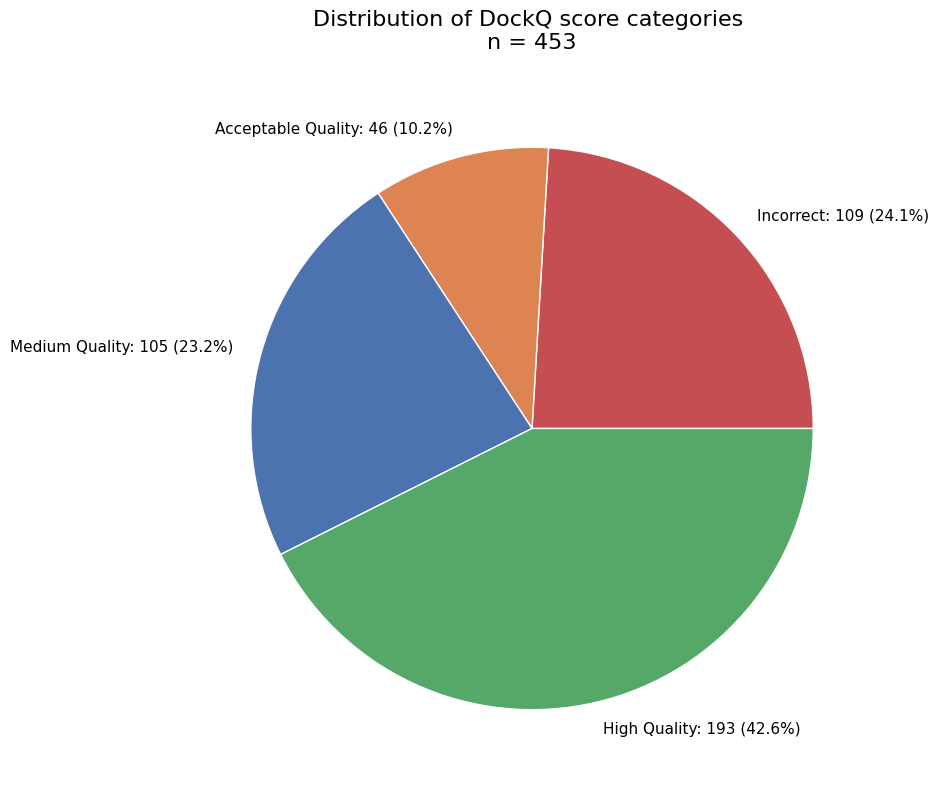

In [111]:
import matplotlib.pyplot as plt

# Define DockQ score categories with their ranges and labels
# Update the High Quality category to use the DOCKQ_CUTOFF variable
categories = {
    'Incorrect': [0, 0.23],
    'Acceptable Quality': [0.23, 0.49],
    'Medium Quality': [0.49, 0.80],
    'High Quality': [0.80, 1.0]
}

# First, filter out NaN DockQ scores
valid_dockq_df = results_df.dropna(subset=['dockq_score']).copy()
print(f"Total data points: {len(results_df)}")
print(f"Data points with valid DockQ scores: {len(valid_dockq_df)}")
print(f"Data points with NaN DockQ scores: {len(results_df) - len(valid_dockq_df)}")

# Create a new column to categorize each data point
def categorize_dockq(score):
    for category, (lower, upper) in categories.items():
        if lower <= score < upper or (category == 'High Quality' and score == upper):
            return category
    return None

valid_dockq_df['dockq_category'] = valid_dockq_df['dockq_score'].apply(categorize_dockq)

# Count the number of data points in each category
category_counts = valid_dockq_df['dockq_category'].value_counts().reindex(categories.keys())
total_points = len(valid_dockq_df)

# Calculate percentages for each category
percentages = (category_counts / total_points * 100).round(1)

# Create labels for the legend with counts and percentages
labels = [f'{cat}: {count} ({pct}%)' for cat, count, pct in 
          zip(category_counts.index, category_counts, percentages)]

# Use seaborn colors but arrange them in order for low to high quality
import seaborn as sns
palette = sns.color_palette("deep")
colors = [palette[3], palette[1], palette[0], palette[2]]  # Red, Yellow-ish, Blue, Green

# Create the pie chart
plt.figure(figsize=(10, 8))

# Create the pie chart with labels directly on slices
wedges, texts, autotexts = plt.pie(category_counts, colors=colors, labels=labels,
                                  wedgeprops={'edgecolor': 'w', 'linewidth': 1},
                                  autopct='', labeldistance=1.1, textprops={'fontsize': 11})

plt.title(f'Distribution of DockQ score categories \nn = {total_points}', 
          fontsize=16, pad=20)

plt.tight_layout()
plt.savefig('/home/markus/Desktop/Thesis/structure_pie.png', dpi=600, bbox_inches='tight')
plt.show()

In [112]:
# Print DockQ scores sorted from high to low with release date and entry ID
# First, select only the necessary columns and remove rows with NaN DockQ scores
score_df = results_df[['Entry ID', 'Release Date', 'dockq_score']].dropna(subset=['dockq_score']).copy()

# Sort by DockQ score from highest to lowest
score_df = score_df.sort_values(by='dockq_score', ascending=False)

# Format the output with consistent spacing
print(f"{'Entry ID':<10} {'Release Date':<12} {'DockQ Score':<10}")
print("-" * 35)

# Print each row
for _, row in score_df.iterrows():
    print(f"{row['Entry ID']:<10} {row['Release Date']:<12} {row['dockq_score']:.4f}")

# Print some summary statistics
print("\nSummary Statistics:")
print(f"Total entries: {len(score_df)}")
print(f"Average DockQ score: {score_df['dockq_score'].mean():.4f}")
print(f"Median DockQ score: {score_df['dockq_score'].median():.4f}")
print(f"Highest DockQ score: {score_df['dockq_score'].max():.4f}")
print(f"Lowest DockQ score: {score_df['dockq_score'].min():.4f}")

Entry ID   Release Date DockQ Score
-----------------------------------
4JQV       2013-06-26   0.9774
1ZVS       2006-06-13   0.9753
5KS9       2016-09-21   0.9737
5LE5       2016-08-17   0.9706
4N3A       2014-01-01   0.9705
5L5A       2016-11-09   0.9699
1YDP       2005-03-08   0.9699
6HLN       2019-07-24   0.9698
6HM8       2019-07-24   0.9697
7EBK       2022-03-09   0.9687
5LE5       2016-08-17   0.9682
1N4P       2003-11-18   0.9673
1REW       2004-05-04   0.9663
4XXB       2015-08-12   0.9642
6E5B       2019-09-11   0.9632
2RFE       2007-12-04   0.9619
3R7G       2011-07-06   0.9603
6J4U       2019-05-01   0.9603
5YBU       2017-12-06   0.9585
1W72       2004-11-09   0.9562
3EMW       2008-10-28   0.9555
7NAO       2022-11-02   0.9544
1D8D       2000-02-09   0.9538
5CTT       2016-04-27   0.9538
5JYL       2016-12-28   0.9529
2F0Y       2006-11-14   0.9527
5ONA       2017-12-27   0.9526
7B5F       2022-01-12   0.9515
6EJG       2018-05-30   0.9502
8XKE       2024-07-10   0.949